# Model Evaluation

While have seen that our model has fairly strong performance metrics, what we really care about is how profitable it is. Theredore we can look at the predicted probabilities for our test set and see how they compare to Bet365 odds. 

### Import Libraries

In [49]:
import pandas as pd
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import xgboost as xgb
import warnings
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Ignore PerformanceWarning and UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### Load Model

In [50]:
# Load model
with open('xg_model2.pkl', 'rb') as file:
    xg = pickle.load(file)

### Load Datasets

In [51]:
# Load datasets
X_test = pd.read_csv('train_test_datasets\X_test2.csv')
X_train = pd.read_csv('train_test_datasets\X_train2.csv')
y_test = pd.read_csv('train_test_datasets\y_test2.csv')
y_train = pd.read_csv('train_test_datasets\y_train2.csv')
odds_win_test = pd.read_csv('train_test_datasets\odds_win_test2.csv')

### Function to show various performance metrics

We can look into more detail how this model has performed by looking at a confusion matrix, a classification report and a ROC-AUC curve:

In [52]:
def evaluate_classification_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a classification model using common performance metrics,
    a confusion matrix heatmap, and an ROC curve.

    Parameters:
        model (fitted estimator): A trained classifier with predict and predict_proba methods.
        X_test (pandas.DataFrame or np.array): Test features.
        y_test (pandas.Series or np.array): True labels for the test set.
        model_name (str): Optional name to display in plots and output.

    Returns:
        dict: A dictionary of the computed performance metrics.
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC Score: {auc:.3f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


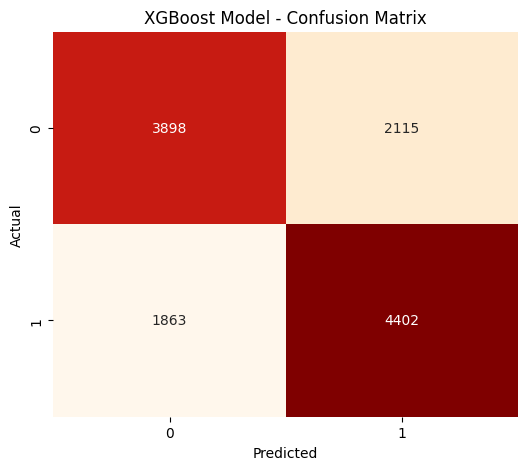

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      6013
           1       0.68      0.70      0.69      6265

    accuracy                           0.68     12278
   macro avg       0.68      0.68      0.68     12278
weighted avg       0.68      0.68      0.68     12278

Accuracy: 0.676
Precision: 0.675
Recall: 0.703
F1 Score: 0.689
ROC AUC Score: 0.736


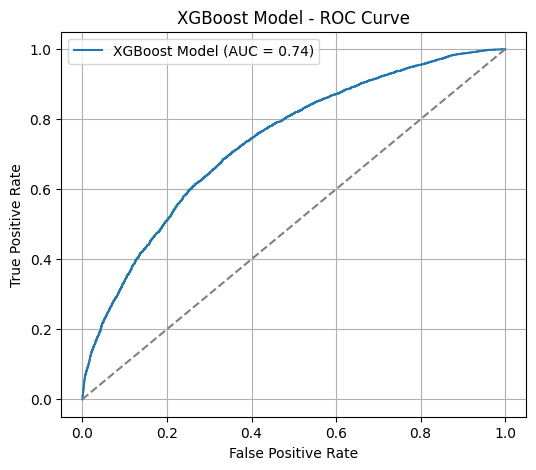

In [53]:
# Run the function
evaluate_classification_model(xg, X_test, y_test, model_name="XGBoost Model")

Whilst this model performs well against multiple performance metrics, these metrics alone are not sufficient when building a betting model, where decision quality is not just about classification, but rather about the confidence in predictions. In a betting context, the key question is not just “Who will win?” but “How sure are we — and are we more sure than the bookmaker?” 

Therefore, we should examine the model’s calibration curve and Brier score. Rather than simply identifying the likely winner, these metrics assess the quality of the predicted probabilities themselves. The calibration curve will compare predicted probabilities to actual observed outcomes; in an ideal model, predictions of 70% confidence should result in roughly 70% actual wins. The Brier score will also quantify the accuracy of these probability estimates by measuring the mean squared difference between predictions and outcomes, with lower scores indicating better calibration and sharper predictions (bookmakers traditionally aim for 0.17-0.21).

In [54]:
def evaluate_probability_calibration(model, y_test, model_name="Model", n_bins=10):
    """
    Plots a calibration curve and prints the Brier score for a probabilistic classifier.

    Parameters:
        y_test (array-like): True binary labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        model_name (str): Optional name of the model for labelling the plot.
        n_bins (int): Number of bins to divide predicted probabilities for calibration.

    Returns:
        float: The Brier score.
    """
    # Compute calibration curve
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=n_bins)

    # Plot calibration curve
    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.title(f'{model_name} - Calibration Curve')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Win Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print Brier score
    brier = brier_score_loss(y_test, y_prob)
    print(f"{model_name} - Brier Score: {brier:.4f}")


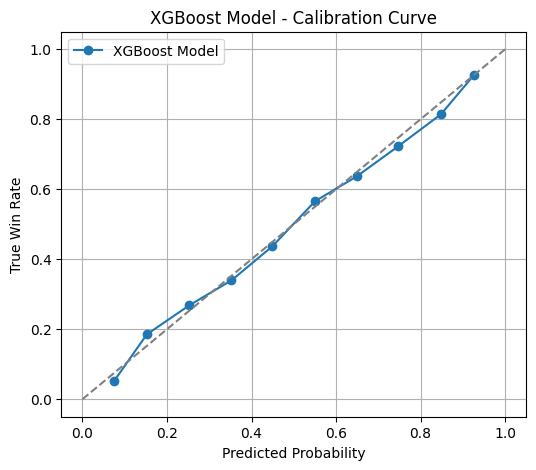

XGBoost Model - Brier Score: 0.2081


In [55]:
# Run the function
evaluate_probability_calibration(xg, y_test, model_name="XGBoost Model", n_bins=10)

We can see that the calibration curve showed that the model’s predicted probabilities track the true win rates closely, suggesting good probability calibration across the range. The Brier score of 0.2081 supports this, placing the model's probability accuracy within the typical range of bookmaker performance. These results indicate that the model is not only capable of predicting match outcomes reasonably well, but is also producing probabilistic forecasts that can be trusted in identifying value in betting markets.

### Function to add model predictions and probabilities to odds dataset

We have our previously saved odds_win_test dataset which contains the results, date, series, surface, round and bookmaker odds from our test dataset. We can now create a function to generate predicted values and probabilities from our test dataset and model, and then add these to our odds_win_test dataset for further analysis:

In [56]:
def add_preds_probs(odds_win_df, X_test, model):
    """
    Adds model predictions and converted probabilities to the odds DataFrame.

    This function:
    - Uses the provided model to predict win probabilities and outcomes on the test set.
    - Converts the predicted probabilities into an odds-style format (1/probability of outcome).
    - Appends both the predicted class and model-derived odds to the given `odds_win_df`.

    Parameters:
        odds_win_df (pandas.DataFrame): A DataFrame containing odds and outcome data for test matches.
        X_test (pandas.DataFrame): The feature set used for testing.
        model (fitted model): A trained classification model with `predict` and `predict_proba` methods.

    Returns:
        pandas.DataFrame: The input DataFrame updated with two new columns:
                          - 'model_odds': Model-derived odds based on predicted win probabilities.
                          - 'pred_win': Predicted binary outcome (win/loss).
    """
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Get probabilities
    y_prob = model.predict_proba(X_test)

    # Convert probabilities to odds format
    y_odds = 1 / y_prob

    # Get only probability of a win
    y_prob = [prob[1] for prob in y_prob]
    y_odd = [odd[1] for odd in y_odds]

    # Add to odds_win_df
    odds_win_df['model_prob'] = y_prob
    odds_win_df['model_odds'] = y_odd
    odds_win_df['pred_win'] = y_pred

    return odds_win_df


In [57]:
# Run the function
odds_win_df = add_preds_probs(odds_win_test, X_test, xg)
odds_win_df.head(5)

,odds,date,Series,Surface,Round,won,model_prob,model_odds,pred_win
0,3.50,2021-05-18,main_tour,clay,round2,1,0.315381,3.170766,0
1,2.62,2021-06-16,main_tour,grass,round2,1,0.439049,2.277650,0
2,5.50,2021-03-11,main_tour,hard,quarterfinal,1,0.295235,3.387138,0
3,2.50,2021-06-03,grand_slam,clay,round2,0,0.167972,5.953374,0
4,1.11,2020-01-30,grand_slam,hard,semifinal,1,0.595328,1.679746,1


We can do some analysis into the bookmaker odds to ensure this data makes sense:

Minimum bookmaker odds: 0.967
Maximum bookmaker odds: 51.0


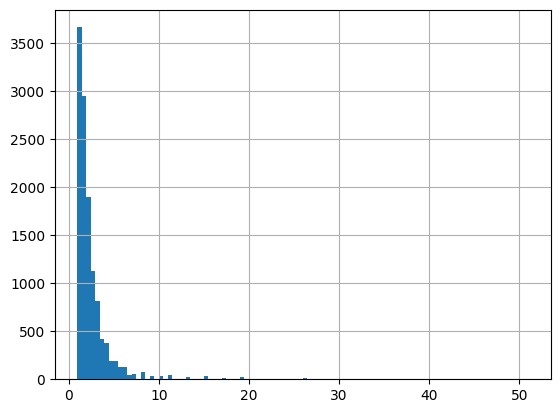

In [58]:
odds_win_df['odds'].hist(bins=100)
print('Minimum bookmaker odds:', odds_win_df['odds'].min())
print('Maximum bookmaker odds:', odds_win_df['odds'].max())

We can see that the majority of these values fall within a logical range of 1.00-10.0, however we can see that we have at least one match where the odds is less than 1.00 which implies a win probability of over 100% which is clearly incorrect. We can also see that that we have odds of up to 51.0. Whilst this could be possible, we would generally expect odds of up to 20.0, so we will remove any odds above this threshold as this could lead to some misleading profit analysis should these be incorrect:

In [59]:
def filter_odds_range(odds_win_df, odds_win_test, X_test, y_test, col='odds', lower=1.0, upper=20.0):
    """
    Filters a DataFrame and associated datasets to include only rows where the odds 
    are within a specified range.

    Parameters:
        odds_win_df (DataFrame): The input DataFrame containing 'odds' and results.
        odds_win_test (DataFrame): The original odds test dataset.
        X_test (DataFrame): Test feature set aligned with df.
        y_test (Series): Test target variable aligned with df.
        col (str): Column name containing odds values.
        lower (float): Lower bound (exclusive).
        upper (float): Upper bound (inclusive).

    Returns:
        tuple: (filtered_df, filtered_X_test, filtered_X_train, filtered_y_test, filtered_y_train)
    """
    original_count = len(odds_win_df)
    mask = (odds_win_df[col] > lower) & (odds_win_df[col] <= upper)
    
    filtered_odds_win_df = odds_win_df[mask]
    filtered_odds_win_test = odds_win_test[mask]
    filtered_X_test = X_test.loc[mask]
    filtered_y_test = y_test.loc[mask]
    
    removed_count = original_count - len(filtered_odds_win_df)
    print(f"Filtered '{col}' between {lower} and {upper}: {removed_count} rows removed")
    
    return filtered_odds_win_df, filtered_odds_win_test, filtered_X_test, filtered_y_test


In [60]:
# Run the function
odds_win_df, odds_win_test, X_test, y_test = filter_odds_range(odds_win_df, odds_win_test, X_test, y_test)
odds_win_df.to_csv('train_test_datasets/odds_win_df.csv', index=False)

Filtered 'odds' between 1.0 and 20.0: 46 rows removed


### Function to show model performance against bookmaker

We can now build a function that shows various performance metrics to compare a betting model against the bookmaker. This function calculates Brier scores for both the model and the bookmaker, simulates value betting based on the model’s predicted probabilities, and reports useful metrics such as return on investment (ROI), hit rate, and the number of value bets identified, in order to evaluate whether the model offers a genuine betting edge over the market.

In [61]:

def compare_model_to_bookmaker(df, model_name="Model"):
    """
    Compares a betting model to the bookmaker using Brier scores and a selective value betting strategy.

    This version aligns with the logic in `returns_lower_odds_and_pred_win`, where:
    - The model predicts a win (`pred_win == 1`)
    - The model's implied odds are lower than the bookmaker's odds (suggesting value)

    Parameters:
        df (DataFrame): Must contain 'odds', 'won', 'model_odds', 'model_prob', and 'pred_win'.
        model_name (str): For display purposes.

    Returns:
        dict: Summary metrics including Brier scores, ROI, hit rate, and number of bets.
    """
    df = df.copy()

    # Brier scores (overall)
    df['bookie_prob'] = 1 / df['odds']
    brier_model = brier_score_loss(df['won'], df['model_prob'])
    brier_bookie = brier_score_loss(df['won'], df['bookie_prob'])

    # Value bet logic aligned with returns_lower_odds_and_pred_win:
    # 1. Model predicts a win
    # 2. Model odds are more confident than bookmaker
    value_bets = df[(df['pred_win'] == 1) & (df['model_odds'] < df['odds'])].copy()

    # Simulate profit/loss for £1 flat stake
    value_bets['profit'] = value_bets.apply(
        lambda row: row['odds'] - 1 if row['won'] == 1 else -1,
        axis=1
    )

    total_return = value_bets['profit'].sum()
    total_staked = len(value_bets)
    roi = (total_return / total_staked) * 100 if total_staked > 0 else 0
    hit_rate = value_bets['won'].mean() if total_staked > 0 else 0

    # Output
    print(f"Model vs Bookmaker Comparison ({model_name})")
    print(f"Brier Score (Model):     {brier_model:.4f}")
    print(f"Brier Score (Bookmaker): {brier_bookie:.4f}")
    print(f"Number of Value Bets:    {total_staked}")
    print(f"ROI on Value Bets:       {roi:.2f}%")
    print(f"Hit Rate on Value Bets:  {hit_rate:.2%}")


In [62]:
# Run the function
compare_model_to_bookmaker(odds_win_df, model_name="XGBoost")

Model vs Bookmaker Comparison (XGBoost)
Brier Score (Model):     0.2088
Brier Score (Bookmaker): 0.2042
Number of Value Bets:    3365
ROI on Value Bets:       8.57%
Hit Rate on Value Bets:  60.51%


The model’s Brier score (0.2088) is slightly higher than the bookmaker’s (0.2042), indicating marginally less accurate probability calibration. However, it identifies 3365 value bets, achieving a positive ROI of 8.57% and a hit rate of 60.51%. While not as well-calibrated overall, the model effectively spots market inefficiencies and shows solid potential for profitable betting.

### Function to plot feature importance

We can now define a function to visualise feature importances and highlight the most influential variables in our model:

In [63]:
def plot_feature_importance(model, X_data):
    """
    Plots the feature importances from a trained XGBoost model.

    Parameters:
    -----------
    model : xgboost.XGBModel
        A trained XGBoost model with the `feature_importances_` attribute.
    
    X_data : pandas.DataFrame
        The feature data (e.g., training or test set) used to obtain column names for labelling.

    Returns:
    --------
    None
        Displays a horizontal bar chart of feature importances.
    """
    # Extract importances
    importances = model.feature_importances_

    # Create a DataFrame for easier plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X_data.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Most important at the top
    plt.tight_layout()
    plt.show()


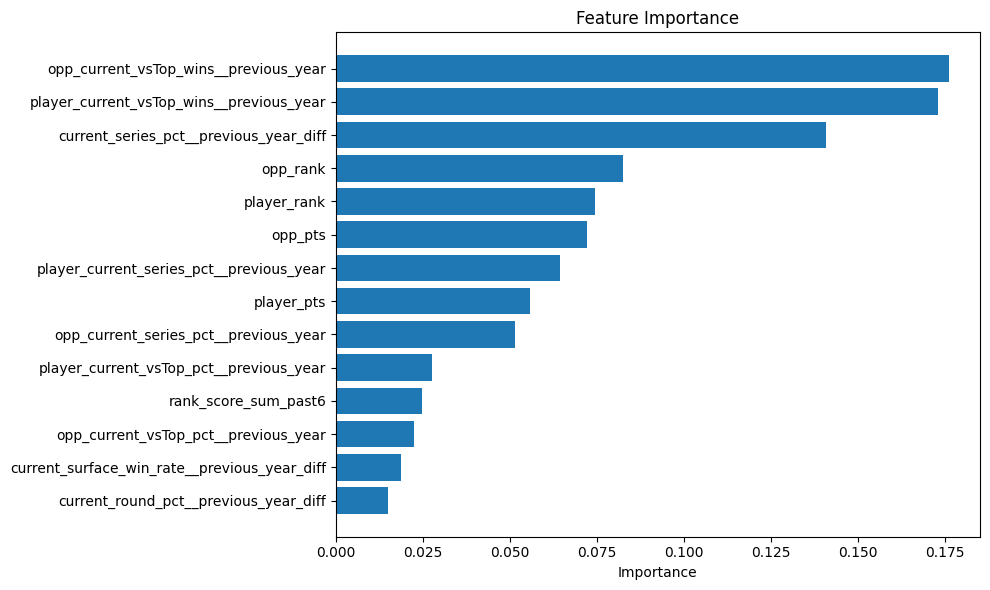

In [64]:
# Run the function 
plot_feature_importance(xg, X_train)

### Function to iteratively filter by number of features and test model performance

We can now build a function to test how our model performs using different numbers of the most important features. It uses XGBoost with Bayesian optimisation to find the best hyperparameters and returns a dataframe showing key metrics like accuracy, F1-score, and Brier score for each feature set:

In [67]:
def xgboost_feature_selection_evaluation(X_train, X_test, y_train, y_test, n_iter=50, step=2):
    """
    Trains XGBoost models using top-N features ranked by importance and evaluates their performance.

    Parameters:
    ----------
    X_train, X_test : pd.DataFrame
        Training and testing feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Target variables.
    n_iter : int
        Number of Bayesian optimisation iterations.
    step : int
        Step size for increasing number of top features.

    Returns:
    -------
    pd.DataFrame
        A DataFrame showing evaluation metrics per top-N feature set size.
    """

    # Initial XGBoost training to get feature importances
    print("Training initial XGBoost model to get feature importances...")
    initial_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    initial_model.fit(X_train, y_train)

    importances = initial_model.feature_importances_
    feature_ranking = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

    results = []

    for top_n in range(step, len(feature_ranking) + 1, step):
        print(f"\nEvaluating with top {top_n} features...")

        top_features = feature_ranking.index[:top_n]

        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        search_space = {
            "n_estimators": Integer(100, 500),
            "max_depth": Integer(3, 12),
            "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
            "subsample": Real(0.5, 1.0),
            "colsample_bytree": Real(0.5, 1.0)
        }

        print("Starting Bayesian optimisation using Brier Score...")
        opt = BayesSearchCV(
            estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
            search_spaces=search_space,
            n_iter=n_iter,
            scoring='neg_brier_score',
            cv=3,
            n_jobs=-1,
            verbose=0,
            random_state=42
        )

        opt.fit(X_train_subset, y_train)
        print("Optimisation complete.")

        best_model = opt.best_estimator_
        y_pred = best_model.predict(X_test_subset)
        y_proba = best_model.predict_proba(X_test_subset)[:, 1]

        result = {
            "Top_N_Features": top_n,
            "ROC-AUC": roc_auc_score(y_test, y_proba),
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "Brier Score": brier_score_loss(y_test, y_proba),
            "Best Params": opt.best_params_
        }

        results.append(result)
        print(f"Finished evaluation for top {top_n} features.")

    results_df = pd.DataFrame(results)
    return results_df


In [69]:
results_df = xgboost_feature_selection_evaluation(X_train, X_test, y_train, y_test)

Training initial XGBoost model to get feature importances...

Evaluating with top 2 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 2 features.

Evaluating with top 4 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 4 features.

Evaluating with top 6 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 6 features.

Evaluating with top 8 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 8 features.

Evaluating with top 10 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 10 features.

Evaluating with top 12 features...
Starting Bayesian optimisation using Brier Score...
Optimisation complete.
Finished evaluation for top 12 features.

Evaluating with top 14 features...

In [70]:
# Show the results
results_df

,Top_N_Features,ROC-AUC,Accuracy,F1-Score,Precision,Recall,Brier Score,Best Params
0,2,0.698694,0.647891,0.676724,0.637894,0.720588,0.220802,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
1,4,0.723160,0.665958,0.684868,0.661699,0.709719,0.212635,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
2,6,0.728276,0.668247,0.680019,0.671024,0.689258,0.210614,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
3,8,0.729680,0.674706,0.683276,0.680514,0.686061,0.210099,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
4,10,0.730782,0.673970,0.687901,0.673873,0.702526,0.209850,"{'colsample_bytree': 0.6712959225417866, 'lear..."
5,12,0.732616,0.674215,0.687574,0.674719,0.700927,0.209151,"{'colsample_bytree': 0.5684764356630512, 'lear..."
6,14,0.734652,0.678058,0.691283,0.678308,0.704763,0.208496,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."


### Function to refit model on reduced features

We can see above that the current number of 14 features yields the best performance metrics. Therefore we can now build a function that takes the best performing model from the dataframe and refits the model based on the optimal hyperparameters here (and also reducing the numbers of features should it have been necessary), outputting the new model and reducded X_train and X_test datasets:

In [71]:
def refit_best_brier_model(results_df, xg, X_train, X_test, y_train, y_test):
    """
    Refit XGBoost model using the parameters and features that gave the lowest Brier score.

    Parameters:
    ----------
    results_df : pd.DataFrame
        DataFrame of evaluation results containing 'Brier Score', 'Top_N_Features', and 'Best Params'.
    xg : xgb.XGBClassifier
        Previously trained XGBoost model (used for feature importance extraction).
    X_train, X_test : pd.DataFrame
        Full training and testing datasets.
    y_train, y_test : pd.Series or np.ndarray
        Target values.

    Returns:
    -------
    model : xgb.XGBClassifier
        Refit XGBoost model using best parameters.
    eval_metrics : dict
        Performance metrics on the test set.
    X_train_reduced : pd.DataFrame
        Training set with reduced features.
    X_test_reduced : pd.DataFrame
        Test set with reduced features.
    """

    # Feature importance ranking from given model
    feature_ranking = pd.Series(xg.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Find best row by Brier Score
    best_row = results_df.loc[results_df['Brier Score'].idxmin()]
    top_n = best_row['Top_N_Features']
    best_params = best_row['Best Params']

    # Select top-N features
    top_features = feature_ranking.index[:top_n]
    X_train_reduced = X_train[top_features]
    X_test_reduced = X_test[top_features]

    # Fit final model with best parameters
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, **best_params)
    model.fit(X_train_reduced, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test_reduced)
    y_proba = model.predict_proba(X_test_reduced)[:, 1]

    eval_metrics = {
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Brier Score": brier_score_loss(y_test, y_proba)
    }

    return model, eval_metrics, X_train_reduced, X_test_reduced


In [72]:
# Refit best model using original model's importances
xg_new, final_metrics, X_train_reduced, X_test_reduced = refit_best_brier_model(
    results_df, xg, X_train, X_test, y_train, y_test
)

We can now view the new model's performance metrics and how it compared to the bookmaker's model:

In [73]:
for metric, score in final_metrics.items():
    print(f'{metric}: {float(score):.4f}')

print('\n')

odds_win_df_new = add_preds_probs(odds_win_test, X_test_reduced, xg_new)
compare_model_to_bookmaker(odds_win_df_new, model_name="XGBoost")

ROC-AUC: 0.7332
Accuracy: 0.6732
F1-Score: 0.6873
Precision: 0.6731
Recall: 0.7022
Brier Score: 0.2090


Model vs Bookmaker Comparison (XGBoost)
Brier Score (Model):     0.2090
Brier Score (Bookmaker): 0.2042
Number of Value Bets:    3371
ROI on Value Bets:       8.20%
Hit Rate on Value Bets:  60.49%


We can actually see that the new hyperparameters actually increased the Brier Score and reduced the ROI slightly. Therefore, we can try and re-tune the hyperparameters by fitting the model again using Bayesian Optimisation but upping the number of iterations to 150:

In [207]:
def train_xgboost_brier(X_train, X_test, y_train, y_test, n_iter=500):
    """
    Trains and evaluates an XGBoost model using Bayesian optimisation, prioritising Brier score.

    Parameters:
    ----------
    X_train : pd.DataFrame
        Training feature set.
    X_test : pd.DataFrame
        Test feature set.
    y_train : pd.Series or np.ndarray
        Training target labels.
    y_test : pd.Series or np.ndarray
        Test target labels.
    n_iter : int
        Number of optimisation iterations for BayesSearchCV.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the evaluation metrics and best hyperparameters for the XGBoost model.
    """

    def print_callback(optim_result):
        iteration = len(optim_result.x_iters)
        if iteration % 25 == 0 or iteration == n_iter:
            print(f"Completed iteration {iteration}/{n_iter}")

    search_space = {
        "n_estimators": Integer(100, 500),
        "max_depth": Integer(3, 12),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0)
    }

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

    opt = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        n_iter=n_iter,
        scoring='neg_brier_score',
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    opt.fit(X_train, y_train, callback=print_callback)

    best_model = opt.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    results = {
        "Model": "XGBoost",
        "Best Params": opt.best_params_,
        "Brier Score": brier_score_loss(y_test, y_proba),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }

    return pd.DataFrame([results])


In [208]:
results_df_new = train_xgboost_brier(X_train_reduced, X_test_reduced, y_train, y_test)

Completed iteration 25/500
Completed iteration 50/500
Completed iteration 75/500
Completed iteration 100/500
Completed iteration 125/500
Completed iteration 150/500
Completed iteration 175/500
Completed iteration 200/500
Completed iteration 225/500
Completed iteration 250/500
Completed iteration 275/500
Completed iteration 300/500
Completed iteration 325/500
Completed iteration 350/500
Completed iteration 375/500
Completed iteration 400/500
Completed iteration 425/500
Completed iteration 450/500
Completed iteration 475/500
Completed iteration 500/500


In [ ]:
# Load results
results_df_new

,Model,Best Params,Brier Score,ROC-AUC,Accuracy,F1-Score,Precision,Recall
0,XGBoost,"{'colsample_bytree': 0.5320435470590371, 'lear...",0.208801,0.733453,0.673479,0.689038,0.671676,0.707321


### Function to fit model on final hyperparameters

We can now build a function to fit a model on the best performing hyperparameters based on the results above:

In [219]:
def refit_best_xgboost_model(results, X_train, y_train):
    """
    Refit an XGBoost model using the best hyperparameters from the results dict.

    Parameters:
    ----------
    results : dict
        Dictionary output from train_and_evaluate_xgboost containing best params and metrics.
    X_train : pd.DataFrame
        Training features.
    y_train : pd.Series or np.ndarray
        Training labels.

    Returns:
    -------
    XGBClassifier
        A refitted XGBoost model with the best hyperparameters.
    """
    best_params = results["Best Params"][0]
    
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        **best_params
    )

    model.fit(X_train, y_train)
    return model


In [ ]:
# Refit on the entire training set using the best params
xg_final = refit_best_xgboost_model(results_df_new, X_train_reduced, y_train)

We can now view the results:

In [230]:
# Show the results
for metric, score in list(results_df_new.items())[2:]:
    print(f'{metric}: {float(score):.4f}')

print('\n')

# Show additional metrics
odds_win_df_new = add_preds_probs(odds_win_test, X_test_reduced, xg_final)
compare_model_to_bookmaker(odds_win_df_new, model_name="XGBoost")

Brier Score: 0.2088
ROC-AUC: 0.7335
Accuracy: 0.6735
F1-Score: 0.6890
Precision: 0.6717
Recall: 0.7073


Model vs Bookmaker Comparison (XGBoost)
Brier Score (Model):     0.2088
Brier Score (Bookmaker): 0.2042
Number of Value Bets:    3291
ROI on Value Bets:       8.94%
Hit Rate on Value Bets:  59.83%


We can see that whilst we have the same Brier Score as our first model, this new model has marginally improved the ROI, therefore we can save this model and the reduced X_train and X_test datasets to files:

In [231]:
# Save model to file
with open('xg_model_new.pkl', "wb") as file:
    pickle.dump(xg_new, file)

# Save datasets to file
X_train_reduced.to_csv('train_test_datasets/X_train_red.csv', index=False)
X_test_reduced.to_csv('train_test_datasets/X_test_red.csv', index=False)
odds_win_df_new.to_csv('train_test_datasets/odds_win_df_new.csv', index=False)

### Function to compare model performance across different factors

We can now build a function to plots bar charts showing how the Brier score of the model compares across different surfaces, series, rounds and at different points of the year:

In [ ]:
def plot_brier_charts_with_counts(df):
    # Ensure date is datetime
    df["date"] = pd.to_datetime(df["date"])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Brier Score by Series with counts
    series_grouped = df.groupby("Series")
    series_scores = series_grouped.apply(lambda x: brier_score_loss(x["won"], x["model_prob"]))
    series_counts = series_grouped.size()
    axes[0, 0].bar(series_scores.index, series_scores.values, label='Brier Score')
    for i, count in enumerate(series_counts):
        axes[0, 0].text(i, series_scores[i], f'n={count}', ha='center', va='bottom')
    axes[0, 0].set_title("Brier Score by Series")
    axes[0, 0].set_ylabel("Brier Score")
    axes[0, 0].set_xticks(range(len(series_scores)))
    axes[0, 0].set_xticklabels(series_scores.index, rotation=45)

    # Brier Score by Surface with counts
    surface_grouped = df.groupby("Surface")
    surface_scores = surface_grouped.apply(lambda x: brier_score_loss(x["won"], x["model_prob"]))
    surface_counts = surface_grouped.size()
    axes[0, 1].bar(surface_scores.index, surface_scores.values, label='Brier Score')
    for i, count in enumerate(surface_counts):
        axes[0, 1].text(i, surface_scores[i], f'n={count}', ha='center', va='bottom')
    axes[0, 1].set_title("Brier Score by Surface")
    axes[0, 1].set_ylabel("Brier Score")
    axes[0, 1].set_xticks(range(len(surface_scores)))
    axes[0, 1].set_xticklabels(surface_scores.index, rotation=45)

    # Brier Score by Round with counts
    round_grouped = df.groupby("Round")
    round_scores = round_grouped.apply(lambda x: brier_score_loss(x["won"], x["model_prob"]))
    round_counts = round_grouped.size()
    axes[1, 0].bar(round_scores.index, round_scores.values, label='Brier Score')
    for i, count in enumerate(round_counts):
        axes[1, 0].text(i, round_scores[i], f'n={count}', ha='center', va='bottom')
    axes[1, 0].set_title("Brier Score by Round")
    axes[1, 0].set_ylabel("Brier Score")
    axes[1, 0].set_xticks(range(len(round_scores)))
    axes[1, 0].set_xticklabels(round_scores.index, rotation=45)

    # Quarterly Brier Score with counts
    df["quarter"] = df["date"].dt.to_period("Q")
    quarter_grouped = df.groupby("quarter")
    quarterly_scores = quarter_grouped.apply(lambda x: brier_score_loss(x["won"], x["model_prob"]))
    quarterly_counts = quarter_grouped.size()
    axes[1, 1].bar(quarterly_scores.index.astype(str), quarterly_scores.values, label='Brier Score')
    for i, count in enumerate(quarterly_counts):
        axes[1, 1].text(i, quarterly_scores[i], f'n={count}', ha='center', va='bottom')
    axes[1, 1].set_title("Quarterly Brier Score")
    axes[1, 1].set_ylabel("Brier Score")
    axes[1, 1].set_xticks(range(len(quarterly_scores)))
    axes[1, 1].set_xticklabels(quarterly_scores.index.astype(str), rotation=45)

    plt.tight_layout()
    plt.show()
    

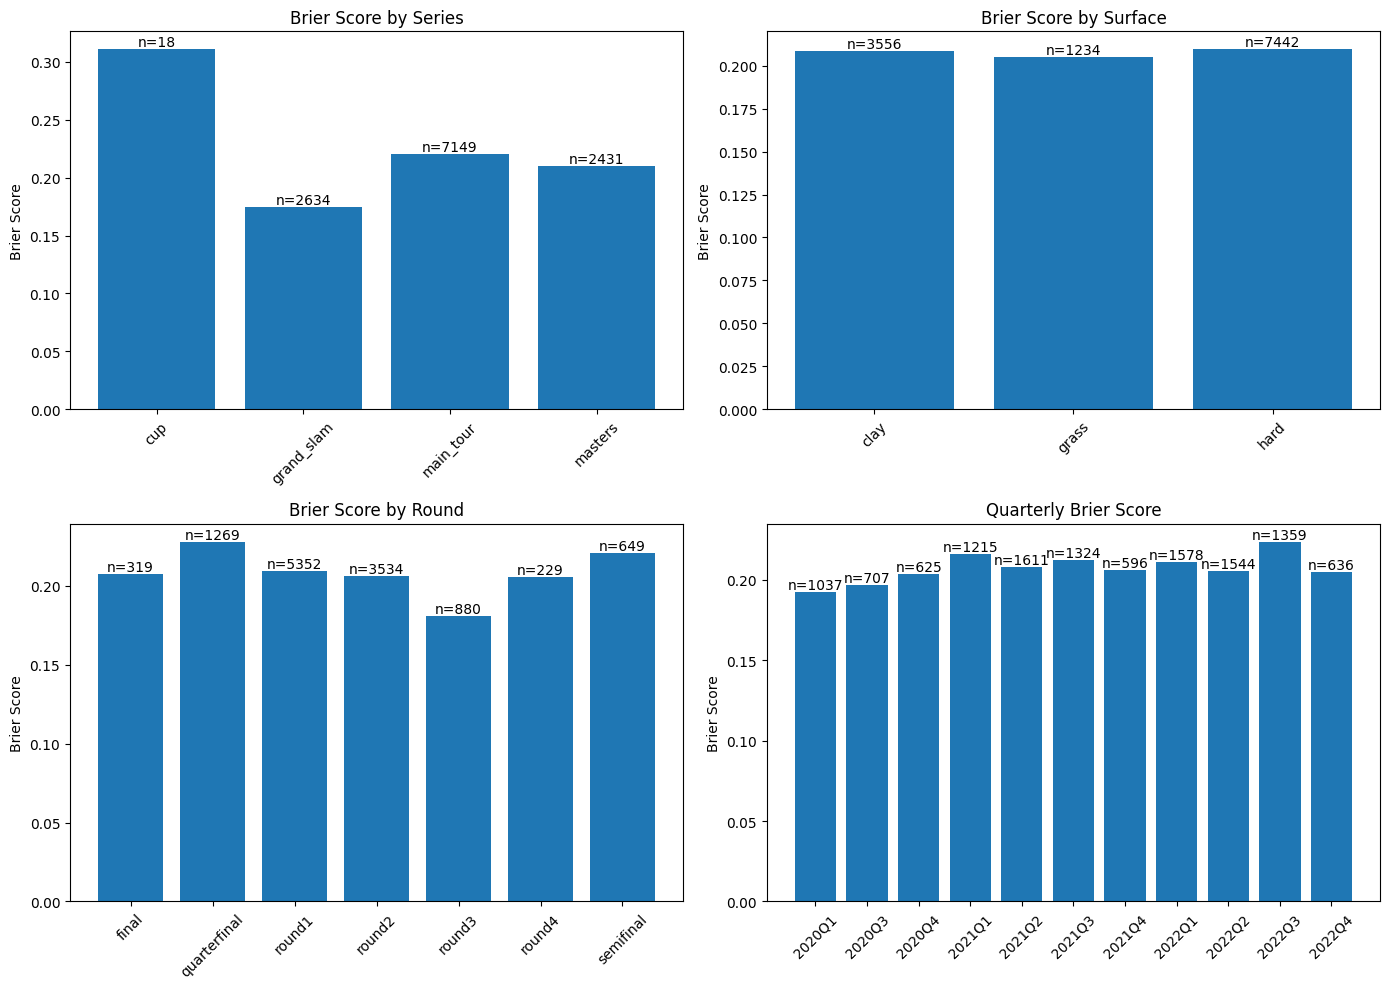

In [233]:
plot_brier_charts_with_counts(odds_win_df_new)

The Brier score breakdowns suggest some variation in model performance across different contexts. For instance, Grand Slam matches and round 3 fixtures tend to produce slightly better Brier scores, while cup events and semifinals show weaker performance, though those categories also have relatively small sample sizes, which may skew the results. 

That said, the differences across most groups are relatively minor and consistent, indicating that the model performs reasonably well across all scenarios. The gains from training separate models for each surface, round, or series are unlikely to outweigh the additional risk of overfitting, especially in categories with fewer data points. Therefore, it is probably best to keep the one model to cover all scenarios. 